In [1]:
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)

In [2]:
os.chdir('..')

In [3]:
import pickle

from hydra import compose, initialize
from omegaconf import OmegaConf

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import torch

from tqdm.notebook import tqdm

from src.preprocessing.new_data_preprop import preprocessing
from src.datamodules.autoencoder import AEDataModule
from src.networks.lstm import LSTMAE

%load_ext autoreload
%autoreload 2

In [26]:
BEST_MODEL_PATH = 'logs/lstm/checkpoints/lstm__embed_dim128_num_layers_1_user_embed_32_masked_pred_0.2-v2.ckpt'

In [5]:
with initialize(config_path='../config', version_base=None):
    cfg = compose(config_name='config')
cfg_preprop = cfg['dataset']
cfg_model = cfg['autoencoder']

In [173]:
seq_data, data_srt = preprocessing(cfg_preprop, return_preproc=True)

In [175]:
data_srt['count_temp'] = data_srt.groupby('sample_label')['sample_label'].count()

In [180]:
data_srt.drop(
        index=data_srt[(data_srt['count_temp'] < 40) | (data_srt['count_temp'] > 120)].index,
        axis=0
    )

,user_id,mcc_code,transaction_amt,transaction_dttm,is_income,sample_label,target,count_temp
40,1,1,6.026347,2020-09-20 08:43:05,0,1,0.0,40.0
50,1,15,4.990066,2020-09-25 04:04:25,0,1,0.0,40.0
103,1,20,6.025567,2020-10-24 23:45:34,0,2,0.0,40.0
128,1,1,3.342567,2020-11-10 00:25:07,0,3,0.0,41.0
138,1,1,6.407349,2020-11-26 02:16:14,0,3,0.0,41.0
...,...,...,...,...,...,...,...,...
19160987,22533,1,3.706910,2021-07-31 05:33:03,0,481243,0.0,NaN
19160988,22533,1,5.625801,2021-07-31 08:57:02,0,481243,0.0,NaN
19160989,22533,1,4.927959,2021-07-31 08:59:33,0,481243,0.0,NaN
19160990,22533,11,4.454891,2021-08-01 23:04:41,0,481243,0.0,NaN


In [177]:
data_srt[(data_srt['count_temp'] < 40) | (data_srt['count_temp'] > 120)].index

Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       12059, 12060, 12061, 12062, 12063, 12064, 12065, 12066, 12067, 12068],
      dtype='int64', length=10523)

In [172]:
seq_data

,user_id,mcc_code,is_income,transaction_amt,target
sample_label,,,,,
0,1,"[1, 2, 2, 3, 1, 4, 5, 1, 4, 1, 6, 1, 2, 1, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[5.8890782152884285, 4.922270128420835, 4.9333...",0.000000
1,1,"[1, 12, 4, 3, 14, 2, 4, 1, 4, 2, 15, 16, 2, 1,...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[6.0263467036668334, 9.354824711478289, 4.6838...",0.025641
2,1,"[1, 4, 11, 3, 4, 1, 4, 2, 19, 3, 4, 1, 4, 1, 4...","[0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[5.677461633888145, 4.9405905124028475, 10.439...",0.000000
3,1,"[4, 3, 11, 21, 21, 3, 6, 1, 20, 15, 11, 3, 4, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...","[5.095079072067337, 5.932747262978507, 7.22032...",0.000000
4,1,"[1, 11, 15, 7, 17, 11, 15, 24, 24, 11, 2, 1, 4...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[6.487398285124865, 6.464628178284367, 6.45578...",0.026316
...,...,...,...,...,...
481239,22533,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 48, 1,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[5.355194268545022, 7.228597283177507, 5.72364...",0.000000
481240,22533,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 33, 9, 1, 27, 1, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[5.6642124044848625, 5.708500925239155, 5.0548...",0.000000
481241,22533,"[11, 1, 11, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[4.420713792050053, 6.0492947505245525, 6.2712...",0.000000


In [7]:
datamodule = AEDataModule(
        None,
        seq_data,
        cfg_preprop['user_column'],
        cfg_preprop['mcc_column'],
        cfg_preprop['transaction_amt_column'],
        cfg_model['data_split']['val_size'],
        1,
        cfg_preprop['preproc']['len_max'],
        4,
        .5,
        False,
        binarize=False
    )

In [8]:
datamodule.setup('test')
dataloader = datamodule.test_dataloader()

In [9]:
best_model = LSTMAE.load_from_checkpoint(BEST_MODEL_PATH)

In [10]:
if not os.path.exists('data/new_data/results/'):
    os.mkdir('data/new_data/results/')

if not os.path.exists(
    f'data/new_data/results/model_{BEST_MODEL_PATH.split("/")[-1].split(".")[0]}.npy'
):
    results = np.zeros((len(dataloader), 5), dtype=np.float32)

    with torch.no_grad():
        for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
            outputs = best_model.predict_step(batch, i)
            results[i, 0] = batch[-1].cpu().numpy()
            results[i, 1] = outputs[0].cpu().numpy()
            results[i, 2:] = np.array(outputs[1])
    np.save(
        f'data/new_data/results/model_{BEST_MODEL_PATH.split("/")[-1].split(".")[0]}',
        results
    )
else:
    results = np.load(
        f'data/new_data/results/model_{BEST_MODEL_PATH.split("/")[-1].split(".")[0]}.npy'
    )


  0%|          | 0/481243 [00:00<?, ?it/s]

In [82]:
np.concatenate((seq_data.index.values[:, np.newaxis], results), 1)

array([[0.00000000e+00, 0.00000000e+00, 1.59542835e+00, 7.30775952e-01,
        5.14270505e-03, 3.50381941e-01],
       [1.00000000e+00, 2.56410260e-02, 1.86030121e+01, 1.31568611e+00,
        1.67518809e-01, 5.35445809e-01],
       [2.00000000e+00, 0.00000000e+00, 1.25115871e+01, 1.15923464e+00,
        1.05364658e-01, 8.15886319e-01],
       ...,
       [4.81241000e+05, 0.00000000e+00, 6.32796764e-01, 2.51682937e-01,
        1.37048285e-03, 2.44065493e-01],
       [4.81242000e+05, 0.00000000e+00, 1.22545123e+00, 4.53629881e-01,
        3.17568518e-03, 4.54252869e-01],
       [4.81243000e+05, 0.00000000e+00, 4.43617868e+00, 1.50234079e+00,
        8.57872888e-03, 2.07596493e+00]])

In [83]:
results = np.concatenate((seq_data.index.values[:, np.newaxis], results), 1)

In [94]:
anomaly_fraq = np.unique(results[:, 1])

In [95]:
losses = []
for fraq in tqdm(anomaly_fraq):
    losses.append(results[np.argwhere(results[:, 1] == fraq)][:, 0, :])

  0%|          | 0/534 [00:00<?, ?it/s]

In [96]:
losses = np.concatenate(losses)
losses_df = pd.DataFrame(losses, columns=['seq_id', 'anomaly_fraq', 'loss', 'mcc_loss', 'binary_loss', 'amt_loss'])

In [109]:
losses_df['seq_id'] = losses_df['seq_id'].astype(np.int32)
losses_df.set_index('seq_id', inplace=True)

In [110]:
losses_df['loss_sum'] = losses_df['mcc_loss'] + losses_df['binary_loss'] + losses_df['amt_loss']

In [111]:
def make_groups(fraq):
    if fraq < .2:
        return 0
    elif .2 <= fraq < .5:
        return 1
    elif .5 <= fraq < .7:
        return 2
    else:
        return 3
    
losses_df['class'] = losses_df['anomaly_fraq'].apply(make_groups)

In [116]:
agg_df = pd.DataFrame(losses_df.groupby('anomaly_fraq').agg({
    'loss': ['mean', 'std'],
    'mcc_loss': ['mean', 'std'],
    'binary_loss': ['mean', 'std'],
    'amt_loss': ['mean', 'std'],
    'loss_sum': ['mean', 'std']
}))

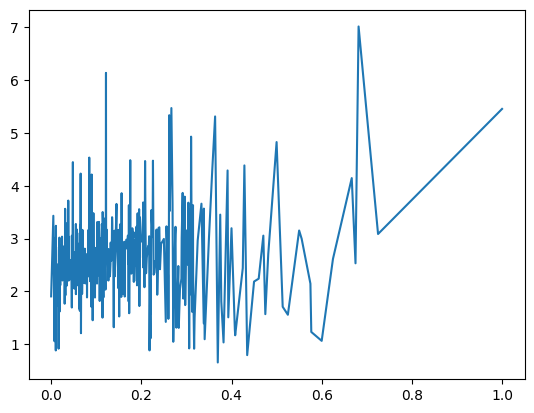

In [113]:
plt.plot(agg_df.index, agg_df['loss_sum']['mean']);

In [115]:
losses_df

,anomaly_fraq,loss,mcc_loss,binary_loss,amt_loss,loss_sum,class
seq_id,,,,,,,
0,0.0,1.595428,0.730776,5.142705e-03,0.350382,1.086301,0
2,0.0,12.511587,1.159235,1.053647e-01,0.815886,2.080486,0
3,0.0,11.977140,1.619344,9.817956e-02,0.539840,2.257364,0
5,0.0,25.044844,1.392464,2.277618e-01,0.876202,2.496427,0
6,0.0,11.992435,1.410223,9.980647e-02,0.601564,2.111594,0
...,...,...,...,...,...,...,...
146891,1.0,0.072103,0.000036,1.753178e-07,0.072049,0.072085,3
233111,1.0,33.193787,6.796909,2.068854e-02,24.328026,31.145624,3
313794,1.0,0.027697,0.000733,1.979942e-11,0.026964,0.027697,3


In [67]:
losses_df[losses_df['anomaly_fraq'] >= .5]['loss_sum'].max()

31.145624

In [49]:
from sklearn.metrics import precision_recall_curve

In [64]:
def get_optimum_threshold(y_true, y_pred_proba):
    precisions, recalls, trs = precision_recall_curve(
        y_true, y_pred_proba
    )

    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    print(f1_scores.max())

    return trs[np.argmax(f1_scores)]

In [72]:
y_true = losses_df['anomaly_fraq'] >= .6

In [73]:
get_optimum_threshold(y_true, losses_df['loss_sum'].values)

0.10526315789473684


31.145624

<BarContainer object of 100 artists>

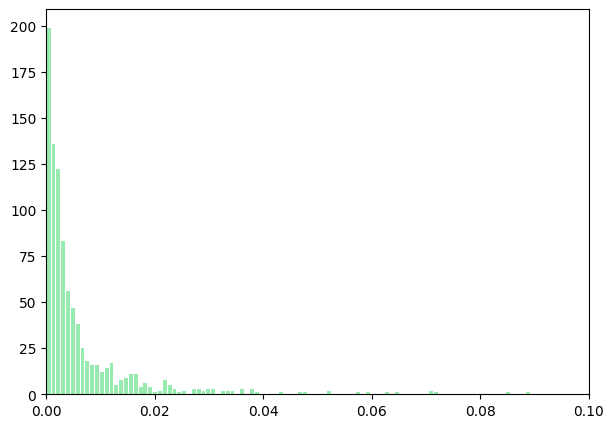

In [119]:
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# Plot Histogram on x
x = losses_df[losses_df['loss'] < .1]['loss']

# Get histogram
hist, bins = np.histogram(x, bins=100)
# hist = hist / np.sum(hist)

# Threshold frequency
freq = 0 #500

# Zero out low values
hist[np.where(hist <= freq)] = 0

# Plot
width = 0.8 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.xlim([0, 0.1])
#plt.margins(0.05)
plt.bar(center, hist, align='center', width=width, color = '#33D860', label='normal', alpha=0.5)

<Axes: xlabel='loss_sum'>

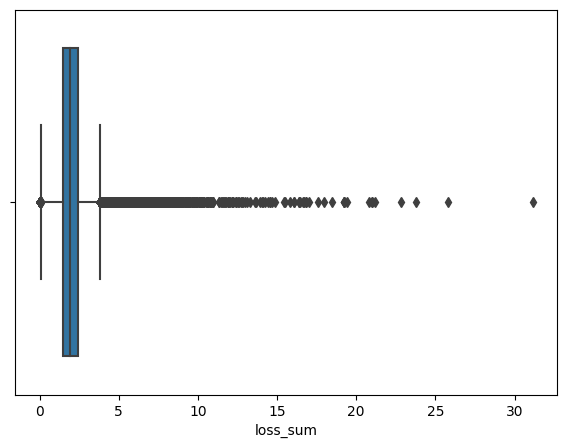

In [120]:
sns.boxplot(x=losses_df['loss_sum'])

Важно! Модель посчитала аномалией набор транзакций с азартными играми (7995 - азартные игры)

user_id - 10682

seq_index - 228781

In [162]:
losses_df[losses_df['loss_sum'] > 20]

,anomaly_fraq,loss,mcc_loss,binary_loss,amt_loss,loss_sum,class
seq_id,,,,,,,
106900,0.0,23.073166,3.290904,0.020689,17.713409,21.025002,0
114053,0.0,27.821541,3.920145,0.020689,21.832542,25.773376,0
168182,0.0,24.901468,3.920145,0.020689,18.912470,22.853303,0
192826,0.0,45.919579,1.038726,0.223977,22.483152,23.745856,0
257582,0.0,22.851784,7.075835,0.020689,13.707093,20.803617,0
375812,0.0,53.783756,0.550530,0.331436,20.089630,20.971596,0
375810,0.5,23.261929,6.309790,0.020701,14.882029,21.212520,2
233111,1.0,33.193787,6.796909,0.020689,24.328026,31.145624,3


In [168]:
seq_data.loc[375812]['mcc_code']

array([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11])

In [91]:
np.exp(seq_data.iloc[228781]['transaction_amt'])

array([ 22.640741, 109.61357 , 104.53754 ,  46.06033 , 146.29277 ,
       906.0762  , 615.7704  ,  42.93056 ,  45.062397,  53.22185 ,
       106.4844  ,  49.638184,  41.42833 , 108.79991 ,  43.768253,
        91.294975,  26.3708  ,  46.409595,  74.03558 , 299.65143 ,
        52.786674,  55.04169 ,  47.810593,  42.436966,  92.17858 ,
        92.656   ,  90.42266 ,  45.48023 ,  54.039265,  55.719685,
       108.61172 , 108.3005  ,  52.05275 , 104.6088  , 165.3661  ,
        94.977066, 443.53137 ,  93.68741 ,  26.717432,  94.710556])

In [169]:
with open('data/new_data/preprocessed/mcc2id.dict', 'rb') as f:
    with open('data/new_data/preprocessed/user2id.dict', 'rb') as f_1:
        mcc2id = dict(pickle.loads(f.read()))
        user2id = dict(pickle.loads(f_1.read()))

In [170]:
id2mcc = {}
id2user = {}
for k, v in mcc2id.items():
    id2mcc[v] = k
for k, v in user2id.items():
    id2user[v] = k

In [171]:
id2mcc[11]

6011

In [92]:
losses_df[losses_df['loss'] > 1]

,anomaly_fraq,loss,mcc_loss,binary_loss,amt_loss,class
27003,0.000,2.301008,1.652921,1.368638e-06,0.647950,0
152523,0.000,1.026022,1.024961,8.510493e-08,0.001053,0
190996,0.000,1.750069,0.000349,1.661448e-02,0.088273,0
228781,0.000,8.238477,0.000121,8.231580e-02,0.006775,0
336094,0.000,1.584863,1.581835,1.119445e-06,0.002917,0
463958,0.075,1.010901,0.997991,1.396667e-06,0.012770,0
472099,0.100,1.370712,1.360427,1.221470e-06,0.010163,0


In [105]:
seq_data.iloc[152523]['mcc_code']

array([ 4, 27,  4, 17, 11, 11,  1,  1,  1,  4,  4,  4, 29, 27, 10,  1,  4,
        3,  1, 27, 79,  4,  4, 45, 45,  1,  1, 83, 20, 10,  9,  9, 83,  4,
        4, 10,  4,  4,  1, 10])

In [106]:
np.exp(seq_data.iloc[152523]['transaction_amt'])

array([  105.706215,   453.6131  ,   637.0809  ,  2113.6567  ,
        3734.1477  ,  5319.124   ,   577.4285  ,   452.62314 ,
        1194.3778  ,    45.360874,   177.24718 ,    93.19953 ,
        2469.5986  ,   827.13464 ,   207.84126 ,   937.9837  ,
         106.322   , 14444.672   ,   669.1018  ,   465.40512 ,
         848.62244 ,    92.386734,   172.4608  ,    18.137623,
         397.60193 ,   514.62616 ,   627.13965 ,  2120.0928  ,
        1160.5157  ,   179.77898 ,   105.38092 ,   789.8764  ,
         741.5316  ,   512.9007  ,    89.932335,    74.01915 ,
         108.026276,   108.19927 ,   787.0158  ,   214.07022 ])

In [107]:
id2mcc[45]

4121

In [79]:
orig_df = pd.read_parquet('data/new_data/transactions.parquet')

In [88]:
orig_df[(orig_df['user_id'] == id2user[10682]) & (orig_df['mcc_code'] == 7995)]

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm
9427255,782283ce1b594f618f8424fe25500c85,7995,48,-40.205284,2020-07-31 06:38:43
9427258,782283ce1b594f618f8424fe25500c85,7995,48,-36.907352,2020-08-01 06:45:14
9427259,782283ce1b594f618f8424fe25500c85,7995,48,-47.200695,2020-08-01 06:53:42
9427260,782283ce1b594f618f8424fe25500c85,7995,48,-36.507774,2020-08-01 07:27:25
9427262,782283ce1b594f618f8424fe25500c85,7995,48,-37.392696,2020-08-01 09:21:51
...,...,...,...,...,...
9428296,782283ce1b594f618f8424fe25500c85,7995,48,-90.043236,2021-01-24 03:22:03
9428297,782283ce1b594f618f8424fe25500c85,7995,48,-211.213870,2021-01-24 04:40:14
9428303,782283ce1b594f618f8424fe25500c85,7995,48,-22.310303,2021-01-26 14:16:54
9428304,782283ce1b594f618f8424fe25500c85,7995,48,-107.449690,2021-01-26 15:33:23
